# Example - A Simple Regression

In [1]:
from funflow import Model, Map, Functional, Rename

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoLars
import networkx as nx
from IPython.display import Image

In [3]:
dataset = fetch_california_housing()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
target = dataset['target']
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3, random_state=42)

In [5]:
fit_layer = Functional(lambda model, X, y: model.fit(X, y), inputs=["Pre - {model_type}", "X_train", "y_train"], outputs=["Trained Simple - {model_type}"], call_type="args", debug=False, name="Fit Simple")
predict_simple_layer = Functional(lambda model, X: model.predict(X), inputs=["Trained Simple - {model_type}", "X_test"], outputs=["Simple Pred - {model_type}"], call_type="args", debug=False, name="Predict Simple")

merge_X = lambda X, y_pred: np.hstack([X, y_pred.reshape((-1, 1))])
fit_boosting_layer = Functional(lambda model, X, y: RandomForestRegressor(n_estimators=10, n_jobs=-1).fit(merge_X(X, model.predict(X)), y), 
                                inputs=["Trained Simple - {model_type}", "X_train", "y_train"], 
                                outputs=["Trained Boosted - {model_type}"], 
                                call_type="args", debug=False, name="Fit Boost")

predict_boosted_layer = Functional(lambda boost_model, simple_model, X: boost_model.predict(merge_X(X, simple_model.predict(X))), 
                                   inputs=["Trained Boosted - {model_type}", "Trained Simple - {model_type}", "X_test"], 
                                   outputs=["Boosted Pred - {model_type}"], 
                                   call_type="args", debug=False, name="Predict Boost")

model_layer = Model([fit_layer, fit_boosting_layer, predict_simple_layer, predict_boosted_layer], 
                    inputs=["Pre - {model_type}", "X_train", "y_train", "X_test"], 
                    outputs=["Trained Simple - {model_type}", "Simple Pred - {model_type}", "Trained Boosted - {model_type}", "Boosted Pred - {model_type}"], debug=False)

In [6]:
model_inputs = {
    "Pre - Linear": LinearRegression(),
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
}

In [7]:
model_inputs.keys()

dict_keys(['Pre - Linear', 'X_train', 'y_train', 'X_test'])

In [8]:
model_outputs = model_layer(**model_inputs)
model_outputs

{'Trained Simple - Linear': LinearRegression(),
 'Simple Pred - Linear': array([0.72604907, 1.76743383, 2.71092161, ..., 2.07465531, 1.57371395,
        1.82744133]),
 'Trained Boosted - Linear': RandomForestRegressor(n_estimators=10, n_jobs=-1),
 'Boosted Pred - Linear': array([0.4737  , 0.7258  , 4.650008, ..., 2.0615  , 1.2838  , 2.5789  ])}

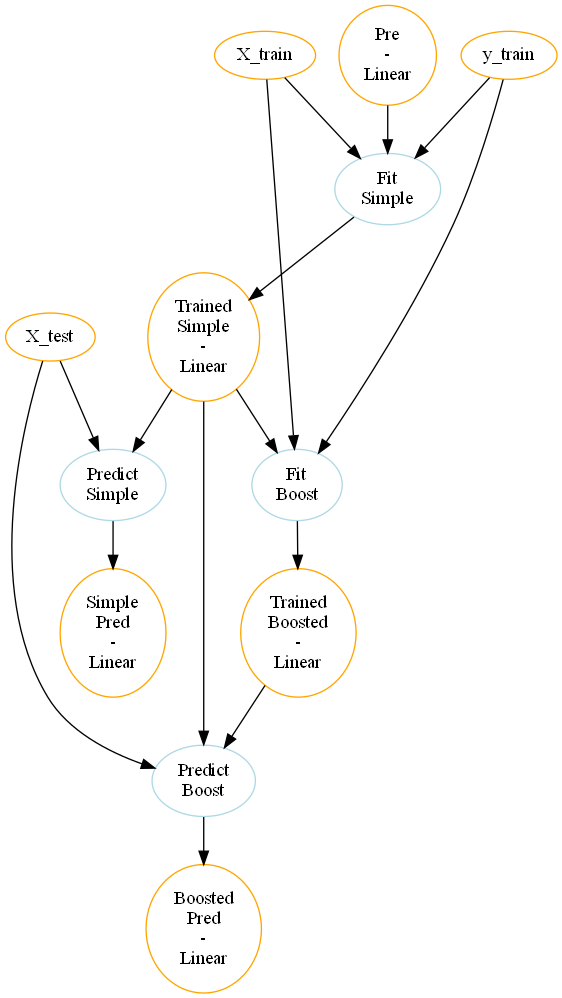

In [9]:
G = model_layer.create_graph(model_inputs)
A = nx.nx_agraph.to_agraph(G)
A.draw('simple_regression.png', prog="dot")
Image('simple_regression.png')

In [10]:
tuple(i for i in range(10))

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [11]:
def no_templates(layer):
    def call_layer(*args):
        kwargs = dict(zip(layer.inputs, args))
        result = layer(**kwargs)
        return tuple(result[output_name] for output_name in layer.outputs)
    return call_layer

In [12]:
print(model_layer)
no_templates(model_layer)(LinearRegression(), X_train, y_train, X_test)

Model Model: 5, 
- Inputs: ['Pre - {model_type}', 'X_train', 'y_train', 'X_test'] -> ['Pre - Linear', 'X_train', 'y_train', 'X_test'], 
- Outputs: ['Trained Simple - {model_type}', 'Simple Pred - {model_type}', 'Trained Boosted - {model_type}', 'Boosted Pred - {model_type}'] -> ['Trained Simple - Linear', 'Simple Pred - Linear', 'Trained Boosted - Linear', 'Boosted Pred - Linear'] 
- Predecessors: []


(LinearRegression(),
 array([0.72604907, 1.76743383, 2.71092161, ..., 2.07465531, 1.57371395,
        1.82744133]),
 RandomForestRegressor(n_estimators=10, n_jobs=-1),
 array([0.5218  , 0.9925  , 4.783404, ..., 1.8288  , 1.2303  , 2.0964  ]))

In [23]:
def normalize(train, test):
    train_mean = np.mean(train)
    train_std = np.std(train)
    
    train_norm = (train - train_mean) / train_std
    test_norm = (test - train_mean) / train_std
    return train_norm, test_norm, train_mean, train_std

def denormalize(data, mean, std):
    return data * std + mean
    
norm_layer = Map(normalize, 
                 name="Normalize",
                 inputs=["{data_type}_train - {dataset_version}", "{data_type}_test - {dataset_version}"], 
                 outputs=["{data_type}_train - {dataset_version}_Norm", "{data_type}_test - {dataset_version}_Norm", "{data_type}_mean - {dataset_version}", "{data_type}_std - {dataset_version}"])

denorm_layer = Map(denormalize,
                 name="DeNormalize",
                   inputs=["{model_version} Pred - {model_type} - {dataset_version}_Norm", "y_mean - {dataset_version}", "y_std - {dataset_version}"],
                   outputs=["{model_version} Pred - {model_type} - Norm"]
                   )

map_models = Map(no_templates(model_layer),
                 name="Map-Model", 
                   inputs=["Pre - {model_type}", "X_train - {dataset_version}", "y_train - {dataset_version}", "X_test - {dataset_version}"], 
                   outputs=["Trained Simple - {model_type} - {dataset_version}", "Simple Pred - {model_type} - {dataset_version}", "Trained Boosted - {model_type} - {dataset_version}", "Boosted Pred - {model_type} - {dataset_version}"], 
                   func_input_type="args", func_output_type="tuple", debug=False)

rename_layer = Rename({"X_train": "X_train - Raw", "y_train": "y_train - Raw", "X_test": "X_test - Raw", "y_test": "y_test - Raw"})

select_prediction = Functional(lambda **kwargs: pd.DataFrame(kwargs),
                               name="Select Prediction",
                               inputs=["{model_version} Pred - {model_type} - Norm", "{model_version} Pred - {model_type} - Raw", "y_test"], 
                               outputs=["Pred DataFrame"])

model = Model([rename_layer, norm_layer, denorm_layer, map_models, select_prediction],
                 name="Pipeline", 
              inputs=["Pre - {model_type}", "X_train", "y_train", "X_test", "y_test"], 
              outputs=["Pred DataFrame"])

model_inputs = {
    "Pre - Linear": LinearRegression(),
    "Pre - LassoLars": LassoLars(),
    "Pre - RandomForest": RandomForestRegressor(n_estimators=10, n_jobs=-1),
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

result = model(**model_inputs)
df = result["Pred DataFrame"]
df

C:\Users\miche\anaconda3\envs\flow\Lib\site-packages\numpy\core\fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Simple Pred - Linear - Norm,Simple Pred - LassoLars - Norm,Simple Pred - RandomForest - Norm,Boosted Pred - Linear - Norm,Boosted Pred - LassoLars - Norm,Boosted Pred - RandomForest - Norm,Simple Pred - Linear - Raw,Simple Pred - Linear - Raw_Norm,Simple Pred - RandomForest - Raw,Simple Pred - RandomForest - Raw_Norm,Simple Pred - LassoLars - Raw,Simple Pred - LassoLars - Raw_Norm,Boosted Pred - Linear - Raw,Boosted Pred - Linear - Raw_Norm,Boosted Pred - RandomForest - Raw,Boosted Pred - RandomForest - Raw_Norm,Boosted Pred - LassoLars - Raw,Boosted Pred - LassoLars - Raw_Norm,y_test
0,0.726049,2.06924,0.478700,0.501500,0.492800,0.437800,0.726049,-1.160472,0.466900,-1.374173,1.724850,-1.524559e-16,0.477500,-1.354474,0.419700,-1.409509,0.497400,-1.361991,0.47700
1,1.767434,2.06924,0.829200,0.575000,0.663400,0.770600,1.767434,-0.260750,0.732800,-1.071353,1.878835,-1.524559e-16,0.649200,-1.290973,0.683700,-1.121981,0.724600,-1.214598,0.45800
2,2.710922,2.06924,4.757307,4.988908,5.000007,5.000008,2.710922,0.554392,4.655007,2.322400,2.151020,-1.524559e-16,4.762808,2.522496,4.870506,2.532086,4.650007,2.532085,5.00001
3,2.835147,2.06924,2.492100,2.682600,2.338600,2.500000,2.835147,0.661719,2.497200,0.365337,2.272701,-1.524559e-16,2.612200,0.529923,2.414200,0.372163,2.671100,0.232718,2.18600
4,2.606958,2.06924,2.274600,2.246400,2.501800,2.189400,2.606958,0.464571,2.330500,0.177424,2.081234,-1.524559e-16,2.492100,0.153061,2.266700,0.103815,2.486300,0.373718,2.78000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187,2.219941,2.06924,1.960500,2.063400,1.954300,1.997200,2.219941,0.130201,2.341800,-0.093947,2.047928,-1.524559e-16,2.301600,-0.005045,2.265800,-0.062240,2.266000,-0.099304,2.37500
6188,0.910516,2.06924,0.668400,0.670500,0.709700,0.648100,0.910516,-1.001098,0.675000,-1.210278,1.794109,-1.524559e-16,0.692900,-1.208464,0.648500,-1.227817,0.671100,-1.174597,0.67300
6189,2.074655,2.06924,1.927400,2.450400,1.958700,1.821600,2.074655,0.004679,2.365200,-0.122545,1.920519,-1.524559e-16,2.323400,0.329310,2.217600,-0.213952,2.531700,-0.095503,2.18400
6190,1.573714,2.06924,1.282800,1.286900,1.484100,1.286100,1.573714,-0.428118,1.606500,-0.679457,1.899937,-1.524559e-16,1.467200,-0.675915,1.614100,-0.676606,1.456800,-0.505541,1.19400


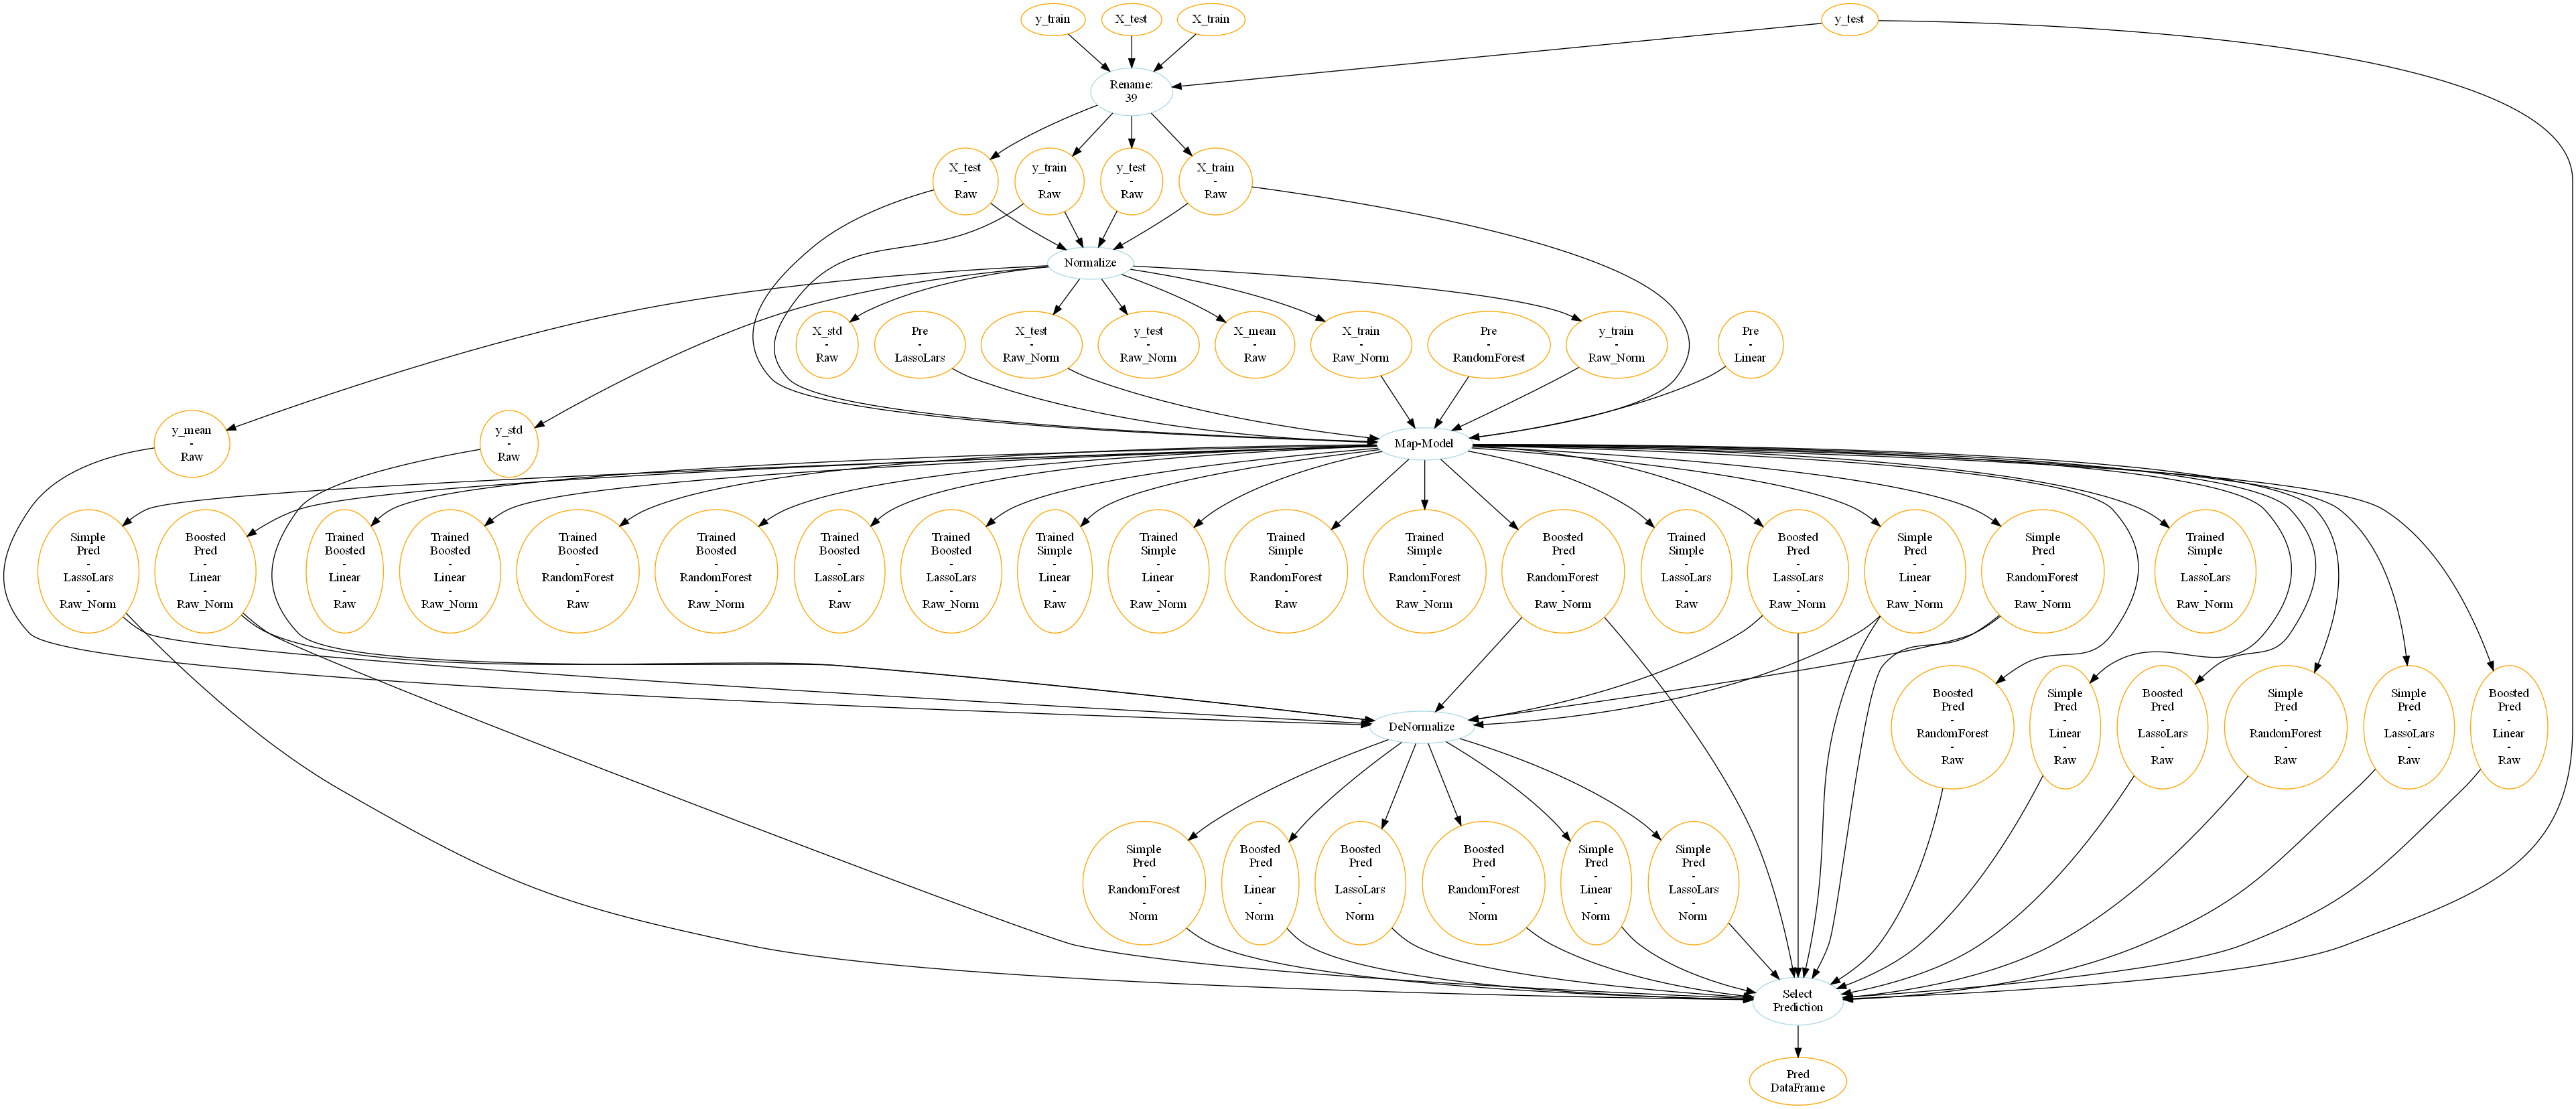

In [24]:
G = model.create_graph(model_inputs)
A = nx.nx_agraph.to_agraph(G)
A.draw('simple_regression.png', prog="dot")
Image('simple_regression.png')

In [25]:
(df
 .subtract(df[["y_test"]].values)
 .drop(columns=["y_test"])
 .pipe(np.abs)
 .describe()
 .round(3)
 .sort_values("mean", axis=1)
 )

,Simple Pred - RandomForest - Norm,Boosted Pred - RandomForest - Norm,Simple Pred - RandomForest - Raw,Boosted Pred - LassoLars - Raw,Boosted Pred - RandomForest - Raw,Boosted Pred - Linear - Raw,Boosted Pred - LassoLars - Norm,Boosted Pred - Linear - Norm,Simple Pred - Linear - Norm,Simple Pred - Linear - Raw,Simple Pred - LassoLars - Raw,Simple Pred - LassoLars - Norm,Boosted Pred - Linear - Raw_Norm,Boosted Pred - LassoLars - Raw_Norm,Simple Pred - RandomForest - Raw_Norm,Boosted Pred - RandomForest - Raw_Norm,Simple Pred - LassoLars - Raw_Norm,Simple Pred - Linear - Raw_Norm
count,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000,6192.000
mean,0.347,0.347,0.348,0.349,0.351,0.351,0.355,0.360,0.527,0.527,0.761,0.906,2.050,2.057,2.059,2.063,2.067,2.071
std,0.394,0.405,0.399,0.393,0.413,0.394,0.402,0.405,0.503,0.503,0.596,0.701,0.547,0.547,0.536,0.533,1.146,0.728
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.017,0.013,0.024,0.000,0.150,0.017
25%,0.089,0.084,0.090,0.094,0.084,0.093,0.091,0.096,0.196,0.196,0.314,0.378,1.761,1.766,1.771,1.785,1.203,1.591
50%,0.222,0.211,0.219,0.220,0.212,0.222,0.226,0.229,0.409,0.409,0.645,0.756,1.952,1.966,1.971,1.983,1.810,1.919
75%,0.451,0.452,0.454,0.460,0.462,0.463,0.475,0.475,0.689,0.689,1.048,1.236,2.256,2.270,2.271,2.271,2.650,2.376
max,3.817,4.089,3.725,3.556,4.094,3.614,3.453,3.790,9.882,9.882,3.424,2.931,5.742,5.408,5.448,5.420,5.000,6.529
